In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

# 设置 matplotlib 字体以匹配 FDM 绘图
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

# 设置随机种子以便复现
torch.manual_seed(42)
np.random.seed(42)

# ----------------------------
# Config
# ----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 物理参数 (来自 Problem 1)
L_DOMAIN = 0.1       # 域尺寸 (m)
K_CONDUCTIVITY = 1.5 # 导热系数 (W/m·K)
H_CONVECTION = 45.0  # 对流换热系数 (W/m²·K)
T_INF = 30.0         # 环境温度 (°C)
T_BOTTOM = 100.0     # 底部恒温 (°C)
Q_FLUX = 2500.0      # 左侧热流 (W/m²)

# PINN 超参数 (来自 Problem 1B)
N_F = 2000           # 内部采样点 (N_f >= 2000)
N_B = 1000           # 边界采样点 (策略2: 增加到1000个点)
LAYERS = 5           # 4 个隐藏层 + 1 个输出层
NEURONS = 64         # 每层神经元
ACTIVATION = nn.Tanh # 激活函数

# 训练参数
LR = 1e-3
EPOCHS = 15000       # 2D 问题通常需要更多次迭代
W_PDE = 1.0          # PDE 损失权重
W_BC = 1.0           # 边界损失权重

print(f"--- 配置信息 ---")
print(f"设备: {DEVICE}")
print(f"域尺寸 L: {L_DOMAIN} m")
print(f"N_f (内部点): {N_F}")
print(f"N_b (边界点): {N_B}")
print(f"网络结构: {LAYERS-1} hidden layers, {NEURONS} neurons/layer")
print(f"\n性能优化:")
print(f"  ✓ 策略1: 批量化边界点计算 (4次前向→1次)")
print(f"  ✓ 策略2: 移除不必要梯度 (底部边界)")
print(f"  预期提升: 30-50% (10min→6-7min)")
print("------------------")

--- 配置信息 ---
设备: cuda
域尺寸 L: 0.1 m
N_f (内部点): 2000
N_b (边界点): 1000
网络结构: 4 hidden layers, 64 neurons/layer

性能优化:
  ✓ 策略1: 批量化边界点计算 (4次前向→1次)
  ✓ 策略2: 移除不必要梯度 (底部边界)
  预期提升: 30-50% (10min→6-7min)
------------------


In [2]:
def xavier_init(m):
    """Xavier 初始化权重"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

def grad(y, x):
    """计算 dy/dx，使用 autograd"""
    return torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y),
        create_graph=True, retain_graph=True
    )[0]

In [3]:
class MLP(nn.Module):
    """
    多层感知机 (MLP) - 全软约束版本
    输入: (x, y) -> 输出: T(x, y)
    所有边界条件都使用软约束（在损失函数中实现）
    """
    def __init__(self, in_dim=2, width=NEURONS, depth=LAYERS, out_dim=1, act=ACTIVATION):
        super().__init__()
        layers = [nn.Linear(in_dim, width), act()]
        # 4 个隐藏层
        for _ in range(depth - 2):
            layers += [nn.Linear(width, width), act()]
        # 输出层
        layers += [nn.Linear(width, out_dim)]
        
        self.net = nn.Sequential(*layers)
        self.net.apply(xavier_init) # 应用 Xavier 初始化

    def forward(self, xy):
        """
        前向传播 - 直接输出温度
        """
        return self.net(xy)

# 实例化模型和优化器
model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("PINN 模型 (全软约束 + 自适应权重 + 残差归一化):")
print(model)

PINN 模型 (全软约束 + 自适应权重 + 残差归一化):
MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [4]:
print(f"正在生成 {N_F} 个内部点和 {N_B} 个边界点 (策略2: 增加边界采样)...")

# 1. 内部点 (PDE Loss)
x_f = L_DOMAIN * torch.rand(N_F, 1)
y_f = L_DOMAIN * torch.rand(N_F, 1)
XY_f = torch.cat([x_f, y_f], dim=1).to(DEVICE).requires_grad_(True)

# 2. 边界点 (BC Loss) - 我们需要所有四个边界
N_B_PER_SIDE = N_B // 4

# (a) 底部 (y=0, Dirichlet) - 策略2: 不需要梯度
x_b_bottom = L_DOMAIN * torch.rand(N_B_PER_SIDE, 1)
y_b_bottom = torch.zeros_like(x_b_bottom)
XY_b_bottom = torch.cat([x_b_bottom, y_b_bottom], dim=1).to(DEVICE)  # 不需要梯度
# 目标温度
T_target_bottom = T_BOTTOM * torch.ones_like(x_b_bottom).to(DEVICE)

# (b) 顶部 (y=L, Robin/Convective) - 需要梯度
x_b_top = L_DOMAIN * torch.rand(N_B_PER_SIDE, 1)
y_b_top = L_DOMAIN * torch.ones_like(x_b_top)
XY_b_top = torch.cat([x_b_top, y_b_top], dim=1).to(DEVICE).requires_grad_(True)

# (c) 左侧 (x=0, Neumann/Flux) - 需要梯度
y_b_left = L_DOMAIN * torch.rand(N_B_PER_SIDE, 1)
x_b_left = torch.zeros_like(y_b_left)
XY_b_left = torch.cat([x_b_left, y_b_left], dim=1).to(DEVICE).requires_grad_(True)

# (d) 右侧 (x=L, Neumann/Insulated) - 需要梯度
y_b_right = L_DOMAIN * torch.rand(N_B_PER_SIDE, 1)
x_b_right = L_DOMAIN * torch.ones_like(y_b_right)
XY_b_right = torch.cat([x_b_right, y_b_right], dim=1).to(DEVICE).requires_grad_(True)

# 策略1: 合并所有边界点用于批量前向传播
# 注意：底部不需要梯度，其他三条边界需要梯度
# cat操作会保留各部分的requires_grad属性
XY_b_all = torch.cat([XY_b_bottom, XY_b_left, XY_b_top, XY_b_right], dim=0)
print(f"边界点合并完成: {XY_b_all.shape[0]} 个点 (底部250点无梯度 + 其他750点有梯度)")

print(f"采样点生成完毕 (四条边界各 {N_B_PER_SIDE} 个).")

正在生成 2000 个内部点和 1000 个边界点 (策略2: 增加边界采样)...
边界点合并完成: 1000 个点 (底部250点无梯度 + 其他750点有梯度)
采样点生成完毕 (四条边界各 250 个).


In [5]:
# 导入 tqdm 用于进度条
from tqdm.auto import trange

print("=" * 60)
print("优化策略实施:")
print("  ✓ 改进的权重策略（限制极端值+强化边界条件）")
print("  ✓ 残差归一化 + 边界采样1000点")
print("  ✓ 策略1: 批量化边界点计算 (4次→1次)")
print("  ✓ 策略2: 移除不必要的梯度计算 (底部)")
print("=" * 60)

# ========================================
# 策略1: 自适应权重初始化
# ========================================
print("\n[策略1] 正在计算初始损失量级...")
model.eval()

# 注意：不使用 torch.no_grad()，因为我们需要计算梯度
# PDE Loss
T_f = model(XY_f)
dT_dXY = grad(T_f, XY_f)
dT_dx, dT_dy = dT_dXY[:, [0]], dT_dXY[:, [1]]
d2T_dx2 = grad(dT_dx, XY_f)[:, [0]]
d2T_dy2 = grad(dT_dy, XY_f)[:, [1]]

# 残差归一化: PDE
T_char = 100.0  # 特征温度 (K)
L_char = L_DOMAIN  # 特征长度
f_res_normalized = (d2T_dx2 + d2T_dy2) * (L_char**2 / T_char)
loss_pde_init = torch.mean(f_res_normalized**2).detach()

# BC Losses (归一化) - 策略1: 批量化计算
# 一次性计算所有边界点的温度（1000点 vs 4次×250点）
T_b_all = model(XY_b_all)

# 分割回四条边界（按照cat的顺序：bottom, left, top, right）
T_b_bottom = T_b_all[:N_B_PER_SIDE]         # [0:250]
T_b_left = T_b_all[N_B_PER_SIDE:2*N_B_PER_SIDE]   # [250:500]
T_b_top = T_b_all[2*N_B_PER_SIDE:3*N_B_PER_SIDE]  # [500:750]
T_b_right = T_b_all[3*N_B_PER_SIDE:]        # [750:1000]

# 底部 (Dirichlet): T = 100 - 策略2: 不需要梯度
res_bottom_normalized = (T_b_bottom - T_target_bottom) / T_char
loss_b_bottom_init = torch.mean(res_bottom_normalized**2).detach()

# 左侧 (热流) - 需要梯度
dT_dx_left = grad(T_b_left, XY_b_left)[:, [0]]
res_left_normalized = (K_CONDUCTIVITY * dT_dx_left + Q_FLUX) / Q_FLUX
loss_b_left_init = torch.mean(res_left_normalized**2).detach()

# 顶部 (对流) - 需要梯度
dT_dy_top = grad(T_b_top, XY_b_top)[:, [1]]
T_char_conv = 100.0  # 特征温差
res_top_normalized = (K_CONDUCTIVITY * dT_dy_top + H_CONVECTION * (T_b_top - T_INF)) / (H_CONVECTION * T_char_conv)
loss_b_top_init = torch.mean(res_top_normalized**2).detach()

# 右侧 (绝热) - 需要梯度
dT_dx_right = grad(T_b_right, XY_b_right)[:, [0]]
res_right_normalized = dT_dx_right / (T_char / L_char)
loss_b_right_init = torch.mean(res_right_normalized**2).detach()

model.train()

# 打印初始损失
print(f"  初始损失 (归一化后):")
print(f"    PDE:   {loss_pde_init.item():.4e}")
print(f"    BC_B:  {loss_b_bottom_init.item():.4e}")
print(f"    BC_L:  {loss_b_left_init.item():.4e}")
print(f"    BC_T:  {loss_b_top_init.item():.4e}")
print(f"    BC_R:  {loss_b_right_init.item():.4e}")

# 改进的权重策略：避免极端值
# 对于初始损失很小的项(PDE, BC_R)，限制最大权重
# 对于需要强化的边界条件(BC_L, BC_B)，给予更高权重
eps = 1e-8

# 计算基础自适应权重
W_PDE_base = 1.0 / (loss_pde_init.item() + eps)
W_BC_L_base = 1.0 / (loss_b_left_init.item() + eps)
W_BC_T_base = 1.0 / (loss_b_top_init.item() + eps)
W_BC_R_base = 1.0 / (loss_b_right_init.item() + eps)
W_BC_B_base = 1.0 / (loss_b_bottom_init.item() + eps)

# 限制最大权重，避免某些项dominate
max_weight = 1e3  # 限制最大权重
W_PDE = min(W_PDE_base, max_weight)
W_BC_R = min(W_BC_R_base, max_weight)

# 边界条件需要强化（特别是BC_L和BC_B）
W_BC_L = min(W_BC_L_base * 100, max_weight)  # 左侧热流×100
W_BC_B = min(W_BC_B_base * 100, max_weight)  # 底部温度×100
W_BC_T = min(W_BC_T_base * 10, max_weight)    # 顶部对流×10

print(f"\n  改进的权重策略:")
print(f"    W_PDE = {W_PDE:.4e} (限制<{max_weight:.0e})")
print(f"    W_BC_B = {W_BC_B:.4e} (×100强化)")
print(f"    W_BC_L = {W_BC_L:.4e} (×100强化)")
print(f"    W_BC_T = {W_BC_T:.4e} (×10强化)")
print(f"    W_BC_R = {W_BC_R:.4e} (限制<{max_weight:.0e})")

print("\n--- 开始训练 (Adam优化器) ---")
start_time = time.time()

# Adam 迭代
# 使用 trange 创建一个带静态描述的进度条
for ep in trange(1, EPOCHS + 1, desc="Adam 训练"):
    
    # ---- PDE Loss (内部) - 残差归一化 ----
    T_f = model(XY_f)
    dT_dXY = grad(T_f, XY_f)
    dT_dx = dT_dXY[:, [0]]
    dT_dy = dT_dXY[:, [1]]
    
    d2T_dx2 = grad(dT_dx, XY_f)[:, [0]]
    d2T_dy2 = grad(dT_dy, XY_f)[:, [1]]
    
    # 归一化PDE残差
    f_res_normalized = (d2T_dx2 + d2T_dy2) * (L_DOMAIN**2 / 100.0)
    loss_pde = torch.mean(f_res_normalized**2)
    
    # ---- BC Losses (软约束边界，归一化) ----
    # 策略1: 批量化边界点前向传播 (4次→1次)
    T_b_all = model(XY_b_all)
    
    # 分割回四条边界
    T_b_bottom = T_b_all[:N_B_PER_SIDE]
    T_b_left = T_b_all[N_B_PER_SIDE:2*N_B_PER_SIDE]
    T_b_top = T_b_all[2*N_B_PER_SIDE:3*N_B_PER_SIDE]
    T_b_right = T_b_all[3*N_B_PER_SIDE:]
    
    # (a) 底部 (Dirichlet) - 策略2: 不需要梯度
    res_bottom_normalized = (T_b_bottom - T_target_bottom) / 100.0
    loss_b_bottom = torch.mean(res_bottom_normalized**2)

    # (b) 左侧 (Flux) - 需要梯度
    dT_dx_left = grad(T_b_left, XY_b_left)[:, [0]]
    res_left_normalized = (K_CONDUCTIVITY * dT_dx_left + Q_FLUX) / Q_FLUX
    loss_b_left = torch.mean(res_left_normalized**2)

    # (c) 顶部 (Convective) - 需要梯度
    dT_dy_top = grad(T_b_top, XY_b_top)[:, [1]]
    res_top_normalized = (K_CONDUCTIVITY * dT_dy_top + H_CONVECTION * (T_b_top - T_INF)) / (H_CONVECTION * 100.0)
    loss_b_top = torch.mean(res_top_normalized**2)
    
    # (d) 右侧 (Insulated) - 需要梯度
    dT_dx_right = grad(T_b_right, XY_b_right)[:, [0]]
    res_right_normalized = dT_dx_right / (100.0 / L_DOMAIN)
    loss_b_right = torch.mean(res_right_normalized**2)
    
    # 应用自适应权重
    loss = (W_PDE * loss_pde) + \
           (W_BC_B * loss_b_bottom) + \
           (W_BC_R * loss_b_right) + \
           (W_BC_L * loss_b_left) + \
           (W_BC_T * loss_b_top)
    
    # Adam 优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 独立打印输出 (显示归一化后的损失和加权损失)
    if ep % 1000 == 0:
        print(f"[Adam ep {ep:5d}] Total={loss.item():.4e} | PDE={loss_pde.item():.4e} | BC_B={loss_b_bottom.item():.4e} | BC_L={loss_b_left.item():.4e} | BC_T={loss_b_top.item():.4e} | BC_R={loss_b_right.item():.4e}")

print(f"Adam 训练完成, 耗时 {(time.time() - start_time):.2f} 秒。")
print("--- 开始 LBFGS 优化 ---")
start_time_lbfgs = time.time()

# LBFGS 优化器
optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=0.1,
    max_iter=5000,
    max_eval=5000,
    history_size=50,
    tolerance_grad=1e-5,
    tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe"
)

# LBFGS 闭包 (应用策略1和策略2)
def closure():
    optimizer_lbfgs.zero_grad()
    
    # PDE - 归一化
    T_f = model(XY_f)
    dT_dXY = grad(T_f, XY_f)
    dT_dx, dT_dy = dT_dXY[:, [0]], dT_dXY[:, [1]]
    d2T_dx2, d2T_dy2 = grad(dT_dx, XY_f)[:, [0]], grad(dT_dy, XY_f)[:, [1]]
    f_res_normalized = (d2T_dx2 + d2T_dy2) * (L_DOMAIN**2 / 100.0)
    loss_pde = torch.mean(f_res_normalized**2)
    
    # BCs - 策略1: 批量化边界点计算
    T_b_all = model(XY_b_all)
    
    # 分割回四条边界
    T_b_bottom = T_b_all[:N_B_PER_SIDE]
    T_b_left = T_b_all[N_B_PER_SIDE:2*N_B_PER_SIDE]
    T_b_top = T_b_all[2*N_B_PER_SIDE:3*N_B_PER_SIDE]
    T_b_right = T_b_all[3*N_B_PER_SIDE:]
    
    # 底部：策略2: 不需要梯度
    res_bottom_normalized = (T_b_bottom - T_target_bottom) / 100.0
    loss_b_bottom = torch.mean(res_bottom_normalized**2)
    
    # 左侧：热流
    dT_dx_left = grad(T_b_left, XY_b_left)[:, [0]]
    res_left_normalized = (K_CONDUCTIVITY * dT_dx_left + Q_FLUX) / Q_FLUX
    loss_b_left = torch.mean(res_left_normalized**2)
    
    # 顶部：对流
    dT_dy_top = grad(T_b_top, XY_b_top)[:, [1]]
    res_top_normalized = (K_CONDUCTIVITY * dT_dy_top + H_CONVECTION * (T_b_top - T_INF)) / (H_CONVECTION * 100.0)
    loss_b_top = torch.mean(res_top_normalized**2)
    
    # 右侧：绝热
    dT_dx_right = grad(T_b_right, XY_b_right)[:, [0]]
    res_right_normalized = dT_dx_right / (100.0 / L_DOMAIN)
    loss_b_right = torch.mean(res_right_normalized**2)
    
    # 应用自适应权重
    loss = (W_PDE * loss_pde) + \
           (W_BC_B * loss_b_bottom) + \
           (W_BC_R * loss_b_right) + \
           (W_BC_L * loss_b_left) + \
           (W_BC_T * loss_b_top)
    
    loss.backward()
    
    if 'lbfgs_step' not in globals():
        globals()['lbfgs_step'] = 0
    globals()['lbfgs_step'] += 1
    
    if globals()['lbfgs_step'] % 100 == 0:
        print(f"[LBFGS step {globals()['lbfgs_step']:5d}] Total={loss.item():.4e} | PDE={loss_pde.item():.4e} | BC_B={loss_b_bottom.item():.4e} | BC_L={loss_b_left.item():.4e} | BC_T={loss_b_top.item():.4e} | BC_R={loss_b_right.item():.4e}")
    
    return loss

# 执行 LBFGS
optimizer_lbfgs.step(closure)
globals().pop('lbfgs_step', None)

print(f"LBFGS 训练完成, 耗时 {(time.time() - start_time_lbfgs):.2f} 秒。")
print("--- 训练全部完成 ---")

优化策略实施:
  ✓ 改进的权重策略（限制极端值+强化边界条件）
  ✓ 残差归一化 + 边界采样1000点
  ✓ 策略1: 批量化边界点计算 (4次→1次)
  ✓ 策略2: 移除不必要的梯度计算 (底部)

[策略1] 正在计算初始损失量级...


/opt/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  初始损失 (归一化后):
    PDE:   6.1309e-12
    BC_B:  9.9986e-01
    BC_L:  1.0002e+00
    BC_T:  8.9743e-02
    BC_R:  2.1085e-08

  改进的权重策略:
    W_PDE = 1.0000e+03 (限制<1e+03)
    W_BC_B = 1.0001e+02 (×100强化)
    W_BC_L = 9.9982e+01 (×100强化)
    W_BC_T = 1.1143e+02 (×10强化)
    W_BC_R = 1.0000e+03 (限制<1e+03)

--- 开始训练 (Adam优化器) ---


Adam 训练:   0%|          | 0/15000 [00:00<?, ?it/s]

[Adam ep  1000] Total=1.2728e+02 | PDE=3.0717e-11 | BC_B=2.0469e-01 | BC_L=1.0000e+00 | BC_T=6.1295e-02 | BC_R=1.2536e-12
[Adam ep  2000] Total=1.2581e+02 | PDE=4.9512e-11 | BC_B=1.3756e-01 | BC_L=1.0000e+00 | BC_T=1.0832e-01 | BC_R=3.0397e-11
[Adam ep  3000] Total=1.2581e+02 | PDE=9.5544e-10 | BC_B=1.3609e-01 | BC_L=9.9999e-01 | BC_T=1.0963e-01 | BC_R=7.8836e-10
[Adam ep  4000] Total=3.2118e+01 | PDE=1.1907e-03 | BC_B=6.0375e-03 | BC_L=2.6471e-01 | BC_T=2.6402e-02 | BC_R=9.1557e-04
[Adam ep  5000] Total=1.8937e+01 | PDE=1.0172e-03 | BC_B=1.8966e-02 | BC_L=1.3895e-01 | BC_T=1.7624e-02 | BC_R=1.6713e-04
[Adam ep  6000] Total=2.2667e+00 | PDE=3.5351e-04 | BC_B=1.0278e-02 | BC_L=7.4666e-03 | BC_T=5.6975e-04 | BC_R=7.5291e-05
[Adam ep  7000] Total=1.0729e+00 | PDE=2.4280e-04 | BC_B=5.9703e-03 | BC_L=1.9452e-03 | BC_T=1.1508e-04 | BC_R=2.5663e-05
[Adam ep  8000] Total=7.8617e-01 | PDE=1.6844e-04 | BC_B=4.5876e-03 | BC_L=1.4017e-03 | BC_T=5.1457e-05 | BC_R=1.3038e-05
[Adam ep  9000] Total=1.

正在绘制 PINN 预测结果...


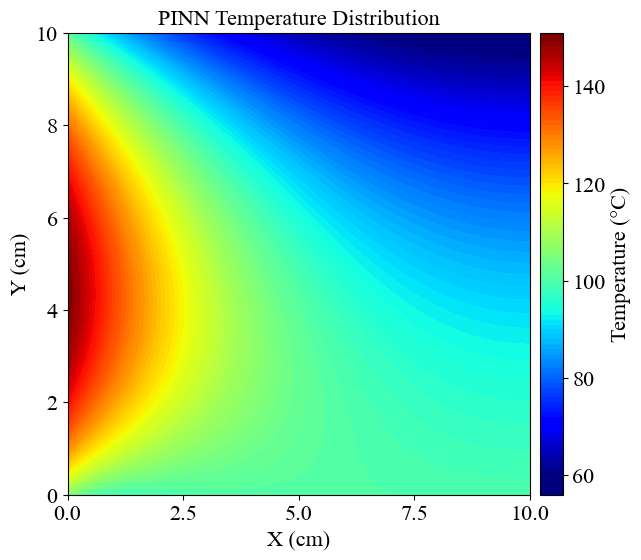

正在绘制 PINN 中线剖面...


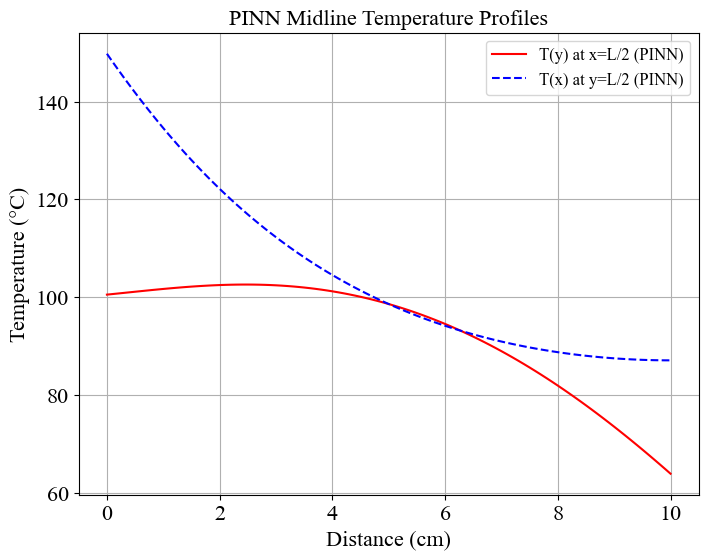

In [6]:
# 导入修复 colorbar 布局所需的工具
from mpl_toolkits.axes_grid1 import make_axes_locatable

print("正在绘制 PINN 预测结果...")

# 1. 设置字体 (与 FDM 保持一致)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 # *** 统一字体大小 ***

# 2. 创建 101x101 绘图网格
N_plot = 101
x_plot = np.linspace(0, L_DOMAIN, N_plot)
y_plot = np.linspace(0, L_DOMAIN, N_plot)
X_plot_np, Y_plot_np = np.meshgrid(x_plot, y_plot)

# 转换为 PyTorch 张量
X_plot_torch = torch.tensor(X_plot_np.ravel(), dtype=torch.float32, device=DEVICE).view(-1, 1)
Y_plot_torch = torch.tensor(Y_plot_np.ravel(), dtype=torch.float32, device=DEVICE).view(-1, 1)
XY_plot_torch = torch.cat([X_plot_torch, Y_plot_torch], dim=1)

# 3. 运行模型
model.eval()
with torch.no_grad():
    T_pinn_flat = model(XY_plot_torch)

# 4. 重塑为 (y, x) 数组
T_pinn = T_pinn_flat.cpu().numpy().reshape((N_plot, N_plot))

# 5. 准备 cm 坐标
x_cm = x_plot * 100
y_cm = y_plot * 100
X_cm, Y_cm = np.meshgrid(x_cm, y_cm)

# 6. 绘制 2D 伪彩图 (严格 FDM 格式)
fig, ax = plt.subplots(figsize=(7, 6))

# *** 修正点: 统一 vmin/vmax/ticks ***
c = ax.contourf(X_cm, Y_cm, T_pinn, levels=100, cmap='jet', vmin=60, vmax=150)

ax.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
    
cbar = fig.colorbar(c, cax=cax, ticks=np.arange(60, 151, 20)) # 60 到 150
cbar.set_label('Temperature (°C)', fontsize=16)

ax.set_xlabel('X (cm)', fontsize=16)
ax.set_ylabel('Y (cm)', fontsize=16)
ax.set_title('PINN Temperature Distribution', fontsize=16) # 标题改为 PINN
ax.set_xticks(np.arange(0, 10.1, 2.5))
ax.set_yticks(np.arange(0, 10.1, 2))

plt.show()

# 7. 绘制中线剖面
# *** 修正点: 合并为一张图 (如 ef0a05.png 所示) ***

print("正在绘制 PINN 中线剖面...")

# 中线索引
mid_i = N_plot // 2  # x = L/2 (i=50)
mid_j = N_plot // 2  # y = L/2 (j=50)

# 提取 PINN 中线数据 (T_pinn[y, x])
T_pinn_profile_x = T_pinn[mid_j, :]    # T(x) at y=L/2
T_pinn_profile_y = T_pinn[:, mid_i]    # T(y) at x=L/2

coords_cm = x_cm # x 和 y 坐标相同

# 绘制 (合并)
fig, ax = plt.subplots(figsize=(8, 6))

# 匹配 ef0a05.png 的格式 (红-实线, 蓝-虚线)
ax.plot(coords_cm, T_pinn_profile_y, 'r-', label='T(y) at x=L/2 (PINN)')
ax.plot(coords_cm, T_pinn_profile_x, 'b--', label='T(x) at y=L/2 (PINN)')

ax.set_xlabel('Distance (cm)', fontsize=16)
ax.set_ylabel('Temperature (°C)', fontsize=16)
ax.set_title('PINN Midline Temperature Profiles', fontsize=16) # 统一标题
ax.legend(fontsize=12)
ax.grid(True)
plt.show()